# Adversarial Patch Attacks

In this notebook we will experiment with **adversarial patch attacks** against a DNN pretrained on ImageNet from robustbench, exploring how the patch can be easily constructed using SecML-Torch.
We aim to have the image of a sports car misclassified, using the $l_∞$ untargeted implementation of PGD-patch {cite:t}`melis2017deep`, a varient of the PGD attack, where using a box constraint the perturbations are restricted to a specific region of the image.

In [1]:
%%capture
try:
    import secmlt
except ImportError:
   %pip install secml-torch[foolbox,adv_lib]

try:
  import robustbench
except ImportError:
   %pip install robustbench
   %pip install git+https://github.com/fra31/auto-attack

In [2]:
%%capture
import torch
import torchvision.datasets
from robustbench.utils import load_model
from secmlt.metrics.classification import Accuracy
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from torch.utils.data import DataLoader, Subset, TensorDataset
import requests, io
from PIL import Image
import torchvision.transforms as T
import json
import matplotlib.pyplot as plt


from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.evasion.pgd import PGD
from secmlt.optimization.constraints import MaskConstraint

#### Loading Pre-trained Model and Dataset

First, we start by loading the pretrained ResNet50 model using RobustBench {cite:t}`croce2020robustbench`, and we pass it to the SecML-Torch wrapper. The ImageNet labels are then loaded and we download a sample image, prepare it for inference and create a dataset loader for it, as the `PGD` class instance expects a dataset loader when running the attack.

In [ ]:
%%capture
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = load_model(model_name="Standard_R50", dataset="imagenet", threat_model="Linf")
net.to(device).eval()
clf = BasePytorchClassifier(net)

labels_url = (
    "https://raw.githubusercontent.com/"
    "anishathalye/imagenet-simple-labels/master/"
    "imagenet-simple-labels.json"
)
r = requests.get(labels_url)
imagenet_labels = json.loads(r.text)

img_url = "https://www.kimballstock.com/images/car-stock-photos/toyota-stock-photos.jpg"
r = requests.get(img_url)
img = Image.open(io.BytesIO(r.content)).convert("RGB")

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
])

img = transform(img).unsqueeze(0)
test_ds = TensorDataset(
    img, 
    torch.tensor([imagenet_labels.index("sports car")])
    )
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

We show the image and the predicted label by the model

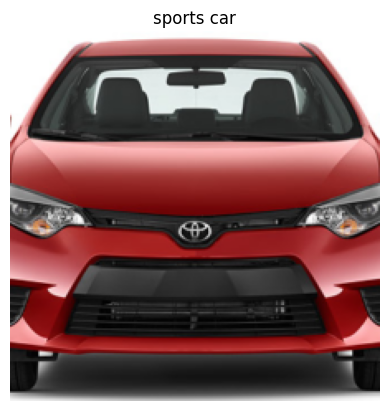

In [4]:
pred_label = imagenet_labels[clf.predict(img.to(device)).item()]

plt.imshow(img.squeeze().permute(1, 2, 0))
plt.title(pred_label)
plt.axis('off')
plt.show()

#### Running the attack

We instantiate the attack instance using our attack parameters, as shown in previous tutorials. However, we further modify the perturbation constraints to account for the box constraint in our PGD-patch attack.
This can be done by creating a mask tensor where only the region which we want to modify has values 1.0, this allows us to constraint the perturbations to that specific region (i.e., patch).
We choose the patch region to be around the license plate of the car.

Note that the PGD-patch attack may take some time to run depending on the machine.

In [ ]:
epsilon = 0.8
steps = 50
step_size = 1e-2
pertubation_norm = LpPerturbationModels.LINF

pgd = PGD(
    perturbation_model=pertubation_norm,
    epsilon=epsilon,
    num_steps=steps,
    step_size=step_size,
    random_start=False,
    backend=Backends.NATIVE,
    lb=0.0, ub=1.0,
)

x_batch, _ = next(iter(test_loader))
B, C, H, W = x_batch.shape
x_lb, x_ub, y_lb, y_ub = 140, 160, 50, 170
mask = torch.zeros(C, H, W, device=x_batch.device)
mask[:, x_lb:x_ub, y_lb:y_ub] = 1.0

pgd.manipulation_function.perturbation_constraints.append(MaskConstraint(mask))

acc_clean = Accuracy()(clf, test_loader)
adv_loader = pgd(clf, test_loader)
acc_adv   = Accuracy()(clf, adv_loader)

print(f"Clean Accuracy.        : {acc_clean:.3f}")
print(f"Robust Accuracy.       : {acc_adv:.3f}")
print(f"Accuracy Drop.         : {acc_clean - acc_adv:.3f}")

Clean Accurcy.        : 1.000
Robust Accurcy.       : 0.000
Drop accuracy         : 1.000


#### Adversarial Patch Visualization

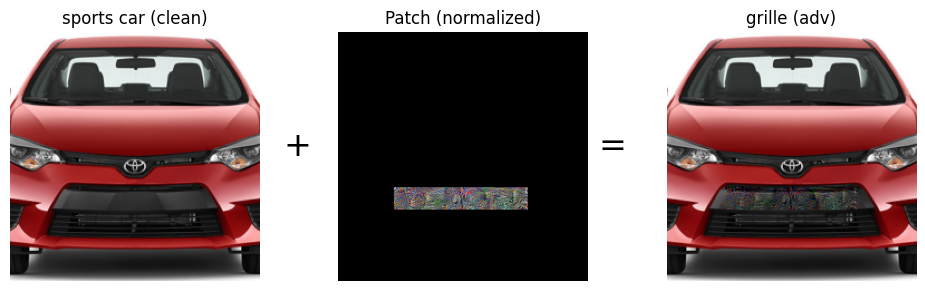

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- grab the same sample from clean and adversarial loaders ---
x_clean_b, y_clean_b = next(iter(test_loader))
x_adv_b,   y_adv_b   = next(iter(adv_loader))

idx = 0
x_clean = x_clean_b[idx].detach().cpu()  # [C,H,W]
x_adv   = x_adv_b[idx].detach().cpu()    # [C,H,W]

# --- predicted labels for titles ---
device = next(net.parameters()).device
with torch.no_grad():
    pred_clean = int(net(x_clean.unsqueeze(0).to(device)).argmax(dim=1).item())
    pred_adv   = int(net(x_adv.unsqueeze(0).to(device)).argmax(dim=1).item())
label_clean = f"{imagenet_labels[pred_clean]} (clean)"
label_adv   = f"{imagenet_labels[pred_adv]} (adv)"

# --- patch coordinates  ---
# x_lb, x_ub, y_lb, y_ub = 140, 160, 50, 170  # e.g., [140:160, 50:170]

# --- build the patch-only perturbation visualization on a WHITE background ---
C, H, W = x_clean.shape
delta = (x_adv - x_clean)  # [C,H,W]

# normalize the patch perturbations
patch = delta[:, x_lb:x_ub, y_lb:y_ub]  # [C,k,k]
dmin, dmax = float(patch.min()), float(patch.max())
patch_norm = (patch - dmin) / (dmax - dmin + 1e-8)      # [C,k,k] in [0,1]

# white background + paste normalized patch
patch_viz = np.zeros((H, W, 3), dtype=np.float32)
patch_viz[x_lb:x_ub, y_lb:y_ub, :] = patch_norm.permute(1, 2, 0).numpy()

# convert clean/adv to HxWxC np arrays for imshow
clean_img = x_clean.permute(1,2,0).clamp(0,1).numpy()
adv_img   = x_adv.permute(1,2,0).clamp(0,1).numpy()

# --- plot: clean | patch | = | adv ---
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

axes[0].imshow(clean_img); axes[0].set_title(label_clean); axes[0].axis("off")
axes[1].imshow(patch_viz); axes[1].set_title("Patch (normalized)"); axes[1].axis("off")
axes[2].imshow(adv_img);   axes[2].set_title(label_adv); axes[2].axis("off")


fig.text(0.335, 0.5,  "+", fontsize=24, ha="center", va="center")
fig.text(0.65, 0.5, "=", fontsize=24, ha="center", va="center")

plt.tight_layout()
plt.show()

```{bibliography}
:filter: docname in docnames
```